In [ ]:
!pip install spacy-sentence-bert
!pip install scikit-learn
!python -m spacy download en_core_web_md
!pip install -U sentence-transformers

In [3]:
import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix

datasets_donwload_urllink = "https://drive.google.com/file/d/10dNvuX8Tk5xgoiCN3ohpyKzaFbYz-r8N/view?usp=drive_link"

In [7]:
nlp = spacy.load("en_core_web_md")

Helper Functions

In [4]:
def anonymize_names_v2(doc):
    text = doc.text
    replacements = {}
    name_id = 1

    for ent in doc.ents:
        if ent.label_ == "PERSON":
            replacements[(ent.start_char, ent.end_char)] = f"[NAME_{name_id}]"
            name_id += 1

    # Sort from last to first to avoid offset shifting
    new_text = text
    for (start, end), placeholder in sorted(replacements.items(), reverse=True):
        new_text = new_text[:start] + placeholder + new_text[end:]

    return new_text, replacements

def deanonymize_text(text, mapping):
    reverse_mapping = {v: k for k, v in mapping.items()}
    for anon, original in reverse_mapping.items():
        text = text.replace(anon, original)
    return text
    # revert back code
    # Add a column with the reverted text
    # df['deanonymized'] = df.apply(lambda row: deanonymize_text(row['anonymized'], row['name_mapping']), axis=1)

def text_topic_similarity(text, topic):
    doc1 = nlp(text)
    doc2 = nlp(topic)

    return doc1.similarity(doc2)

In [5]:
file_id = '10dNvuX8Tk5xgoiCN3ohpyKzaFbYz-r8N'
url = f'https://drive.google.com/uc?id={file_id}'
df = pd.read_csv(url)

In [ ]:
df.columns = ["rowid", "interaction", "label"]
df["anonymized_interaction"] = ''

### Perform Anonymization

In [8]:
anonymized_results = []
replacement_maps = []

for doc in nlp.pipe(df['interaction'], batch_size=50):
    anonymized_text, mapping = anonymize_names_v2(doc)
    anonymized_results.append(anonymized_text)
    replacement_maps.append(mapping)

# Store results
df['anonymized_interaction'] = anonymized_results
df['name_mapping'] = replacement_maps

In [11]:
df_anonymized = df[["rowid", "anonymized_interaction", "label"]]

### Perform Label evaluation and replacement

In [ ]:
df_anonymized = df_anonymized.replace({'label':
    {
        "AccountDetails":"Account Details",
        "Loan":"Loan and Credit Services","HomeLoan":"Loan and Credit Services","AutoLoan":"Loan and Credit Services",
        "DebitCard":"Debit/Credit Card","CreditCard":"Debit/Credit Card",
        "Offers":"Product Inquiries",
        "Grievances":"Complaints",
        "TechSupport":"Technical Support"
    }
})

df_anonymized["original_label_confidence"] = 0
df_anonymized["new_label"] = ""
df_anonymized["new_label_confidence"] = 0

df_anonymized.head(2)

In [13]:
df_anonymized["label_doc"] = df_anonymized["label"].apply(nlp)
df_anonymized["original_label_confidence"] = df_anonymized.apply(
    lambda row: text_topic_similarity(row["anonymized_interaction"], row["label_doc"]) * 100 , axis=1
)

#### Zero shot classification with new topics

In [15]:
from sentence_transformers import SentenceTransformer, util
from tqdm import tqdm
model = SentenceTransformer("all-MiniLM-L6-v2")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [16]:
# List of class labels
topics = ['Account Details', 'New Account', 'Account Inquiries', 'Product Inquiries',
          'Debit/Credit Card Issues', 'Transactions & Payments',  'Loan and Credit Services',
          'Fraud and Security Concerns','Fees and Charges','General Financial Advice', 'Sales'
          'Appointments', 'Technical Support', 'Escalations', 'Complaints', 'Other']

# Precompute embeddings
topics_embeddings = model.encode(topics, convert_to_tensor=True)
text_inputs = df_anonymized["anonymized_interaction"].tolist()
text_embeddings = model.encode(text_inputs, convert_to_tensor=True)

# Store results
predicted_labels = []
confidence_scores = []

for text_emb in tqdm(text_embeddings):
    similarities = util.cos_sim(text_emb, topics_embeddings)
    best_idx = similarities.argmax().item()
    predicted_labels.append(topics[best_idx])
    confidence_scores.append(similarities[0][best_idx].item())

# Add results to the dataframe
df_anonymized["new_label"] = predicted_labels
df_anonymized["new_label_confidence"] = confidence_scores

100%|██████████| 1588/1588 [00:00<00:00, 17212.03it/s]


In [26]:
old_labels = df_anonymized["label"].tolist()
old_label_embeddings = model.encode(old_labels, convert_to_tensor=True)
old_labels_confidence_score = []

for i in range(len(text_embeddings)):
    sim = util.cos_sim(text_embeddings[i], old_label_embeddings[i])
    old_labels_confidence_score.append(sim.item())  # Convert 1x1 tensor to float

df_anonymized['original_label_confidence'] = old_labels_confidence_score

In [27]:
df_anonymized[["label", "label_doc", "original_label_confidence", "new_label", "new_label_confidence"]]

,label,label_doc,original_label_confidence,new_label,new_label_confidence
0,Loan and Credit Services,"(Loan, and, Credit, Services)",0.504656,Loan and Credit Services,0.504656
1,Loan and Credit Services,"(Loan, and, Credit, Services)",0.432348,Loan and Credit Services,0.432348
2,Loan and Credit Services,"(Loan, and, Credit, Services)",0.486659,Loan and Credit Services,0.486659
3,Loan and Credit Services,"(Loan, and, Credit, Services)",0.593414,Loan and Credit Services,0.593414
4,Loan and Credit Services,"(Loan, and, Credit, Services)",0.494564,Fees and Charges,0.519653
...,...,...,...,...,...
1583,Complaints,(Complaints),0.052188,Account Details,0.471679
1584,Complaints,(Complaints),0.162751,Fees and Charges,0.416044
1585,Complaints,(Complaints),0.045095,Loan and Credit Services,0.272788
1586,Complaints,(Complaints),0.348949,Debit/Credit Card Issues,0.584095


In [31]:
#df_anonymized['new_label'].value_counts()

### Label comparison

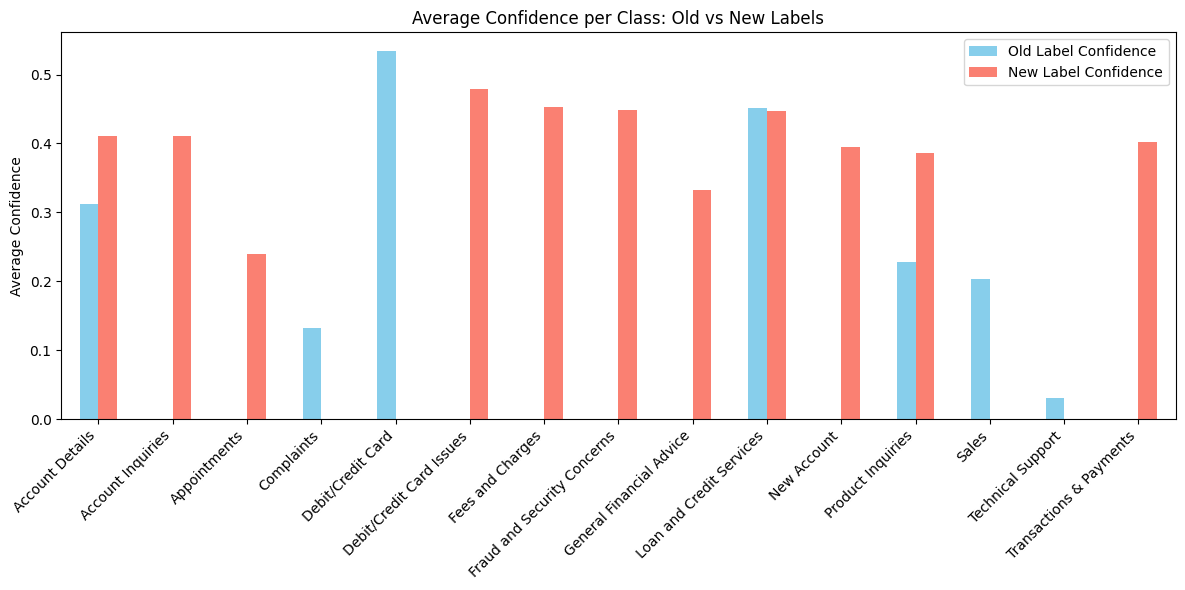

In [29]:
old_avg = df_anonymized.groupby('label')['original_label_confidence'].mean()
new_avg = df_anonymized.groupby('new_label')['new_label_confidence'].mean()

comparison_df = pd.DataFrame({
    'Old Label Confidence': old_avg,
    'New Label Confidence': new_avg
}).fillna(0)

# Plot grouped bar chart
import matplotlib.pyplot as plt
comparison_df.plot(kind='bar', figsize=(12, 6), color=['skyblue', 'salmon'])
plt.ylabel("Average Confidence")
plt.title("Average Confidence per Class: Old vs New Labels")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [36]:
# sales_lines = df_anonymized[df_anonymized['label']=="Sales"]
# for index, row in df.iterrows():
#   print(row["anonymized_interaction"])

### V0 computation

In [ ]:
import spacy_sentence_bert
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score